In [1]:
%%capture
!pip install PyMySQL

In [2]:
import pymysql.cursors
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

## Datenvisualisierung und statistische Analyse

In diesem Notebook werden wir verschiedene statistische Analysen und Visualisierungen auf dem `n14_metabolomics_data`-Datensatz durchführen.

### Schritte im Notebook:
1. Datenbankabfrage: Wir holen die Daten aus einer SQL-Datenbank.
2. Verteilung und Korrelation der Metaboliten: Visualisierung und Analyse der Verteilungen und Zusammenhänge der Metabolitenwerte.
3. Boxplot: Visualisierung der Verteilung der Metabolitenwerte nach Krankheitsstatus.
4. Chi-Quadrat-Test: Statistische Analyse zur Untersuchung des Zusammenhangs zwischen dem Krankheitsstatus und den Geschlechtern.


In [3]:
def connect():
    # database credentials
    host = 'den1.mysql6.gear.host'
    db = 'situation'
    usr = 'situation'
    pwd = input()

    # connect to the database
    try:
        return pymysql.connect(host=host, user=usr, password=pwd, database=db,
            cursorclass=pymysql.cursors.DictCursor)
    except pymysql.Error as err:
        print("error %d: %s" %(err.args[0], err.args[1]))
        return ""

In [4]:
def query_table(table_name):
    sql = f"SELECT * FROM {table_name};"

    # Connect to database
    db_connection = connect()

    # Check connection
    if not (type(db_connection) == str):
        # Execute query and fetch results
        with db_connection.cursor() as cursor:
            cursor.execute(sql)
            result = cursor.fetchall()
            # Get column names
            colnames = [desc[0] for desc in cursor.description]
        # Close the connection
        db_connection.close()
        # Convert to DataFrame
        df = pd.DataFrame(result, columns=colnames)
        return df
    else:
        return pd.DataFrame()  # Return an empty DataFrame if connection fails

# Call the function to query the table
df_results = query_table('n14_metabolomics_data')

# Print out the DataFrame
print(df_results)

aichem567.
    sample_id  metabolite1  metabolite2  metabolite3  metabolite4  \
0    sample_0     0.676405     0.653278     0.506652     0.648825   
1    sample_1     0.540016     0.646936     0.530247     0.689589   
2   sample_10     0.514404     0.461267     0.336980     0.535637   
3   sample_11     0.645427     0.469770     0.546278     0.570657   
4   sample_12     0.576104     0.395145     0.409270     0.501050   
5   sample_13     0.512168     0.357998     0.505195     0.678587   
6   sample_14     0.544386     0.329373     0.572909     0.512691   
7   sample_15     0.533367     0.695078     0.512898     0.540199   
8   sample_16     0.649408     0.449035     0.613940     0.688315   
9   sample_17     0.479484     0.456193     0.376517     0.365224   
10  sample_18     0.531307     0.374720     0.540234     0.372952   
11  sample_19     0.414590     0.577749     0.431519     0.596940   
12   sample_2     0.597874     0.515495     0.436568     0.617878   
13  sample_20     0.244

       metabolite1  metabolite2  metabolite3  metabolite4  metabolite5  \
count    28.000000    28.000000    28.000000    28.000000    28.000000   
mean      0.536727     0.481945     0.467834     0.556357     0.518935   
std       0.110066     0.104916     0.076468     0.107570     0.081899   
min       0.244701     0.301920     0.327372     0.365224     0.390060   
25%       0.483969     0.406626     0.417244     0.476426     0.451467   
50%       0.536692     0.467490     0.463886     0.580631     0.533733   
75%       0.595725     0.539726     0.520869     0.648245     0.567333   
max       0.726975     0.695078     0.613940     0.694362     0.691006   

       metabolite6  metabolite7  metabolite8  metabolite9  metabolite10  \
count    28.000000    28.000000    28.000000    28.000000     28.000000   
mean      0.495786     0.474870     0.522043     0.473684      0.477767   
std       0.109627     0.091505     0.089079     0.090796      0.109316   
min       0.345523     0.277660  

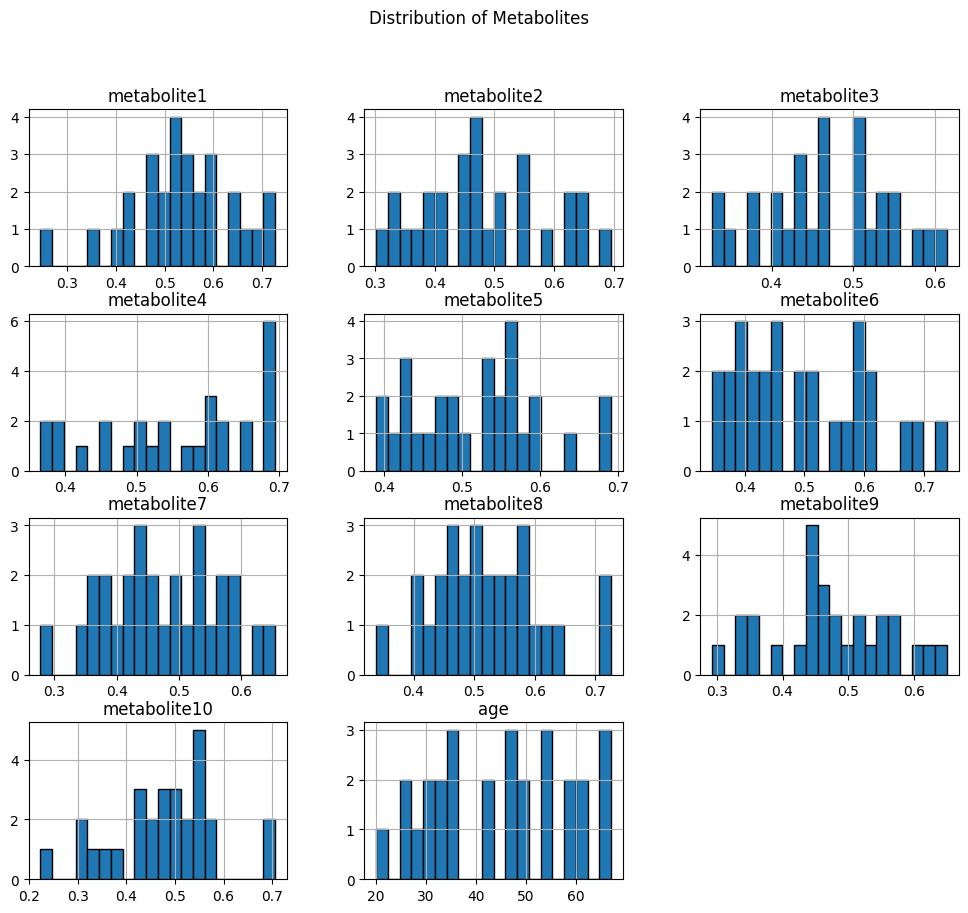

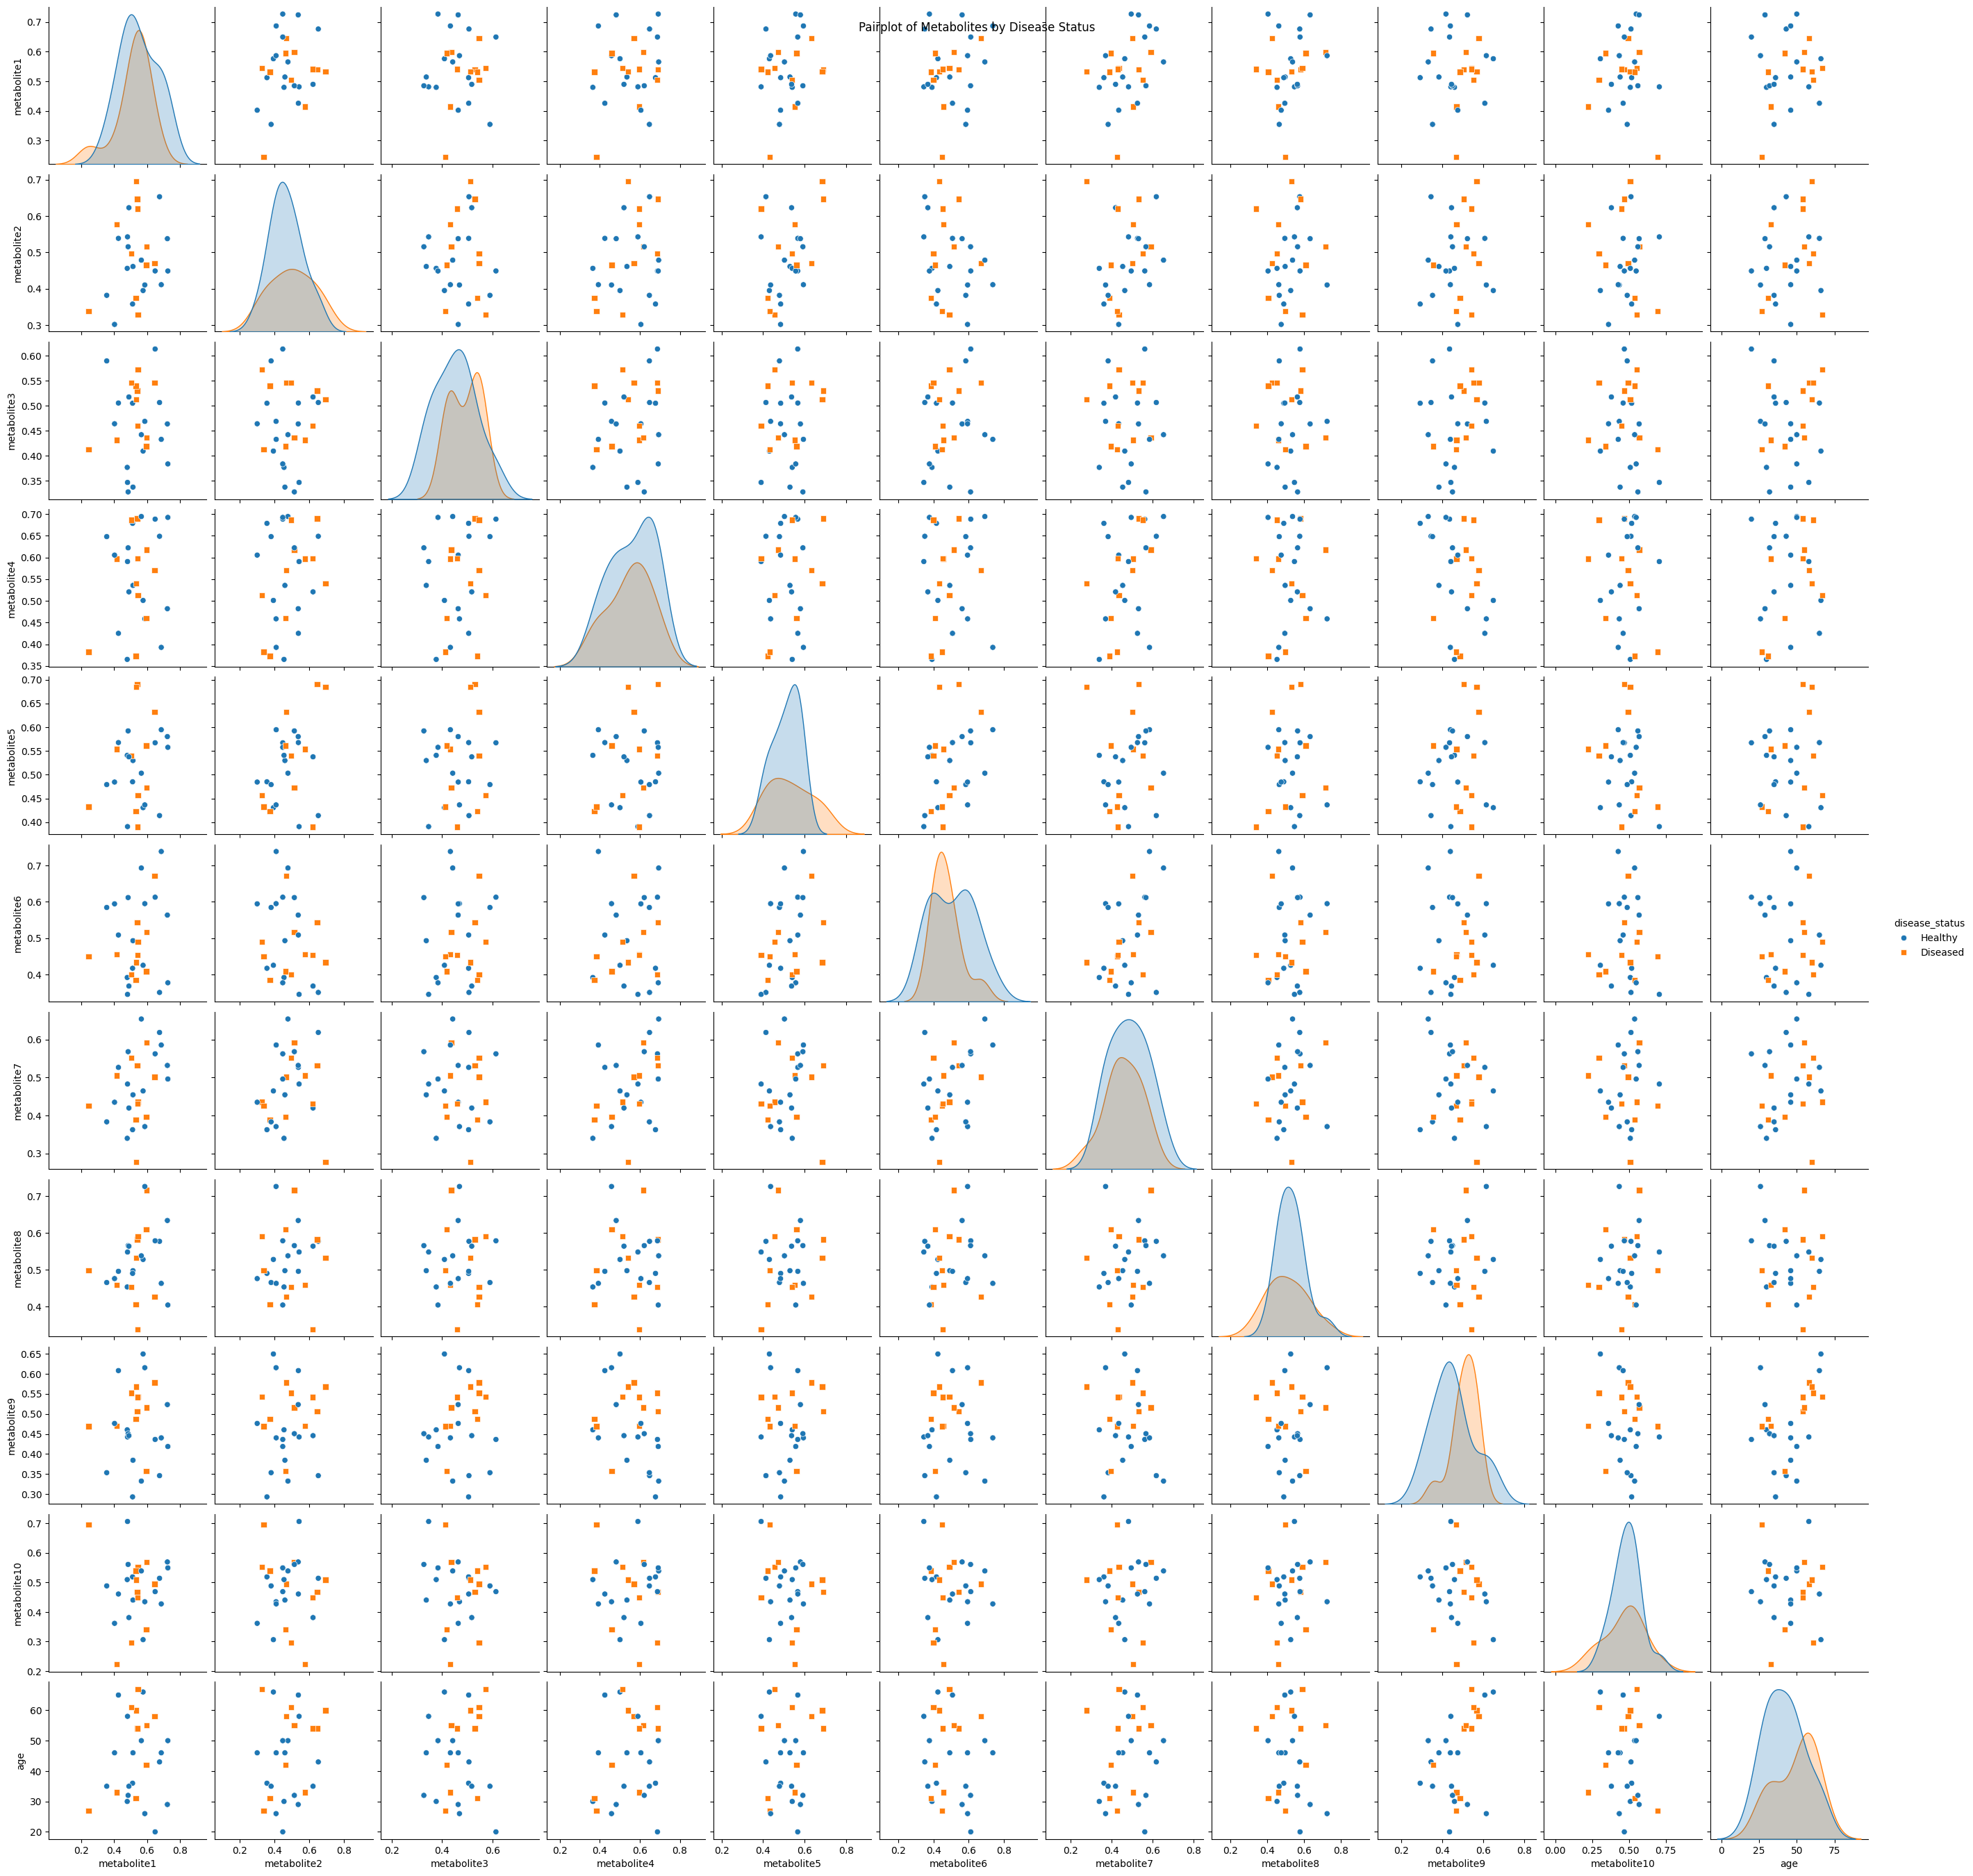

                metabolite1  metabolite2  metabolite3  metabolite4  \
disease_status                                                       
Diseased           0.517483     0.502760     0.491695     0.547972   
Healthy            0.549179     0.468476     0.452395     0.561782   

                metabolite5  metabolite6  metabolite7  metabolite8  \
disease_status                                                       
Diseased           0.530802     0.473632     0.458145     0.510215   
Healthy            0.511256     0.510120     0.485692     0.529696   

                metabolite9  metabolite10        age  
disease_status                                        
Diseased           0.507977      0.467217  49.272727  
Healthy            0.451494      0.484593  41.941176  


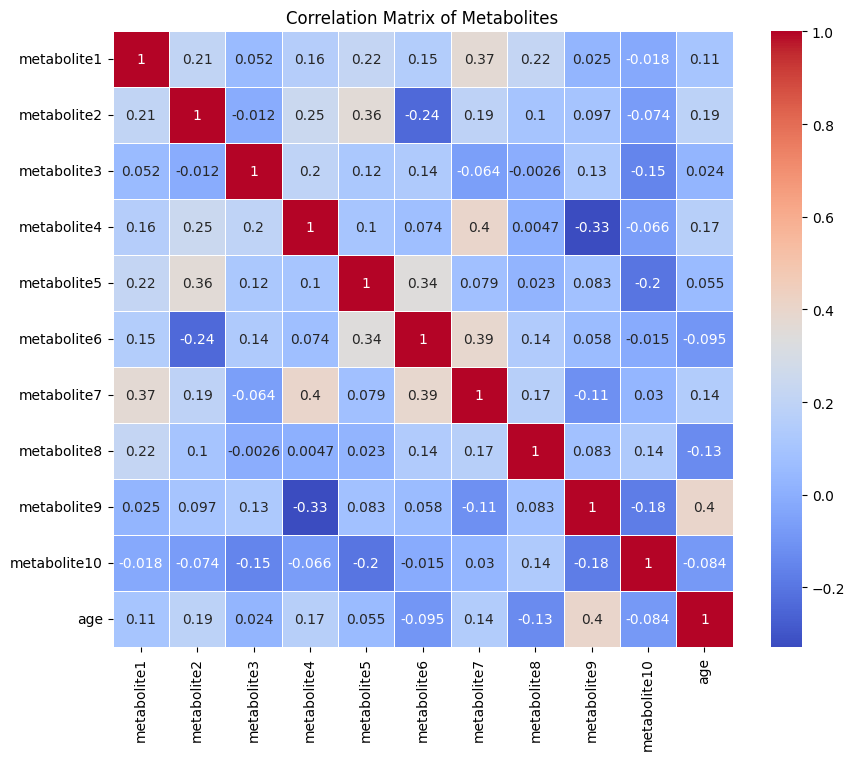

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert columns to appropriate data types
numeric_columns = df_results.select_dtypes(include=['float64', 'int64']).columns
df_numeric = df_results[numeric_columns]

# Add back the non-numeric columns needed for analysis
df_numeric['disease_status'] = df_results['disease_status']

# Print summary statistics for numeric columns
print(df_numeric.describe())

# Visualize the distribution of metabolites
df_numeric.hist(figsize=(12, 10), bins=20, edgecolor='black')
plt.suptitle('Distribution of Metabolites')
plt.show()

# Visualize the relationships between metabolites and disease status
sns.pairplot(df_numeric, hue='disease_status', diag_kind='kde', markers=['o', 's'])
plt.suptitle('Pairplot of Metabolites by Disease Status')
plt.show()

# Compare means of metabolites between Healthy and Diseased groups
grouped = df_numeric.groupby('disease_status').mean()
print(grouped)

# Correlation matrix for numeric columns
df_corr = df_numeric.drop(columns=['disease_status'])  # Drop non-numeric columns
correlation_matrix = df_corr.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Metabolites')
plt.show()


In [6]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
# 3D surface plot for the correlation matrix
def plot_3d_correlation_matrix(correlation_matrix):
    # Convert the correlation matrix to a format suitable for 3D plotting
    z = correlation_matrix.values
    x = correlation_matrix.columns
    y = correlation_matrix.index

    # Create the 3D surface plot
    fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
    fig.update_layout(title='3D Surface Plot of Correlation Matrix',
                      autosize=False,
                      width=700, height=700,
                      margin=dict(l=65, r=50, b=65, t=90))
    fig.show()

# Call the function to plot the 3D correlation matrix
plot_3d_correlation_matrix(correlation_matrix)

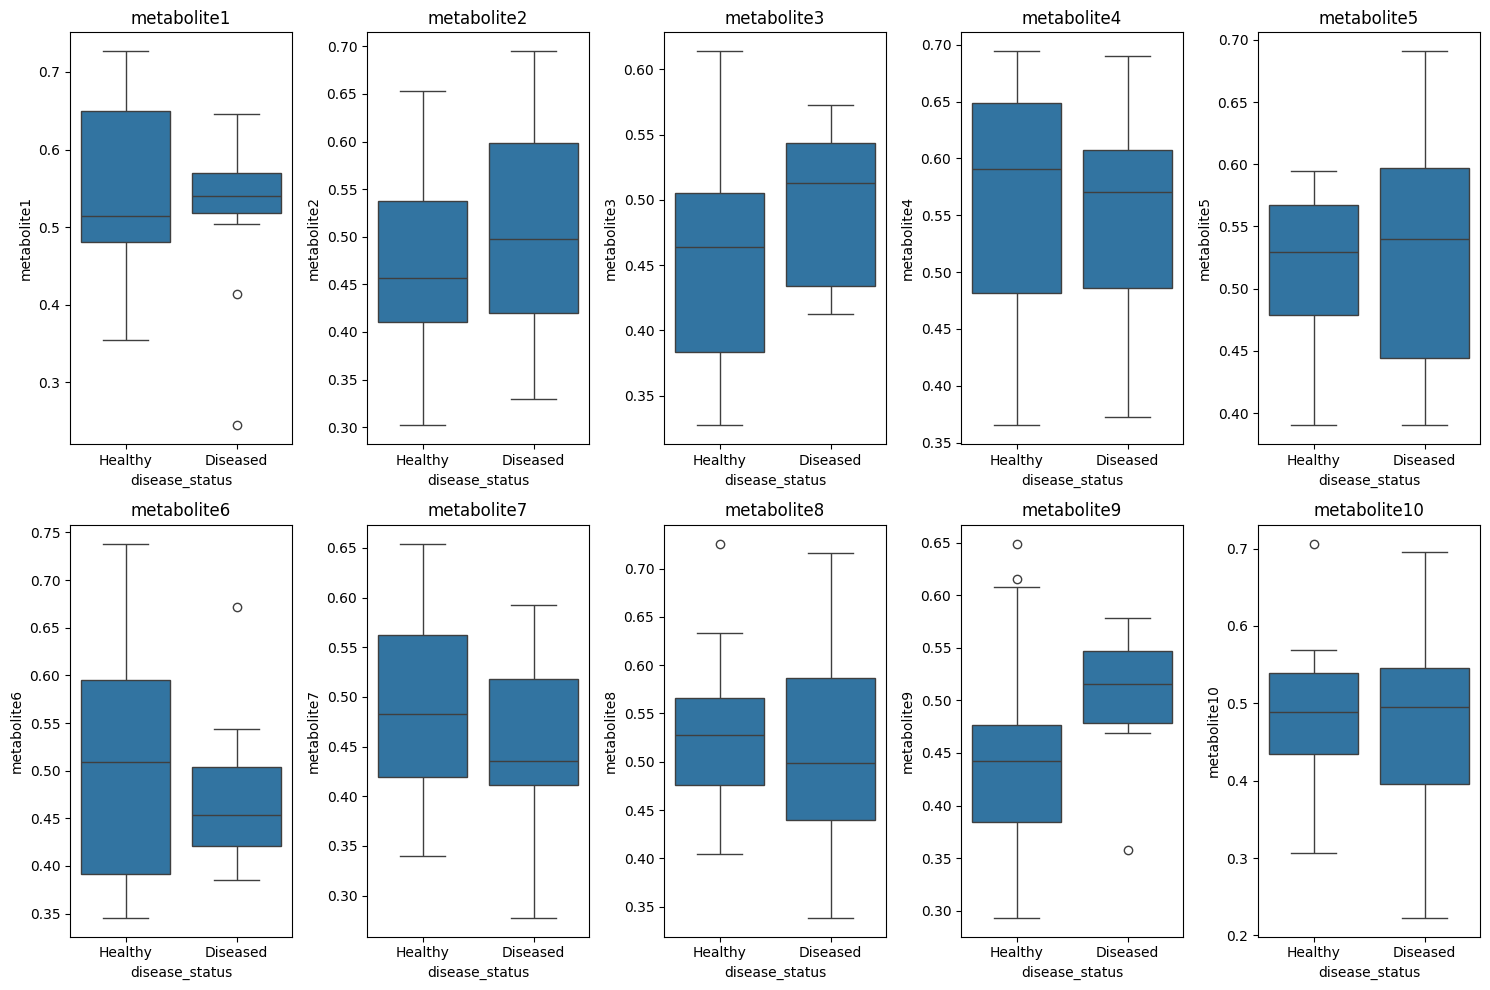

In [7]:
# Boxplots der Metaboliten nach Krankheitsstatus
plt.figure(figsize=(15, 10))
metabolites = [col for col in df_numeric.columns if 'metabolite' in col]
for i, metabolite in enumerate(metabolites):
    plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns
    sns.boxplot(x='disease_status', y=metabolite, data=df_results)
    plt.title(metabolite)
plt.tight_layout()
plt.show()

In [8]:
import pandas as pd
from scipy.stats import chi2_contingency

# Chi-Quadrat-Test für den Zusammenhang zwischen Krankheitsstatus und Geschlecht
contingency_table = pd.crosstab(df_results['disease_status'], df_results['gender'])
chi2, p, dof, ex = chi2_contingency(contingency_table)
print(f"Chi-Quadrat Test: chi2 = {chi2}, p = {p}, dof = {dof}")

Chi-Quadrat Test: chi2 = 0.0, p = 1.0, dof = 1


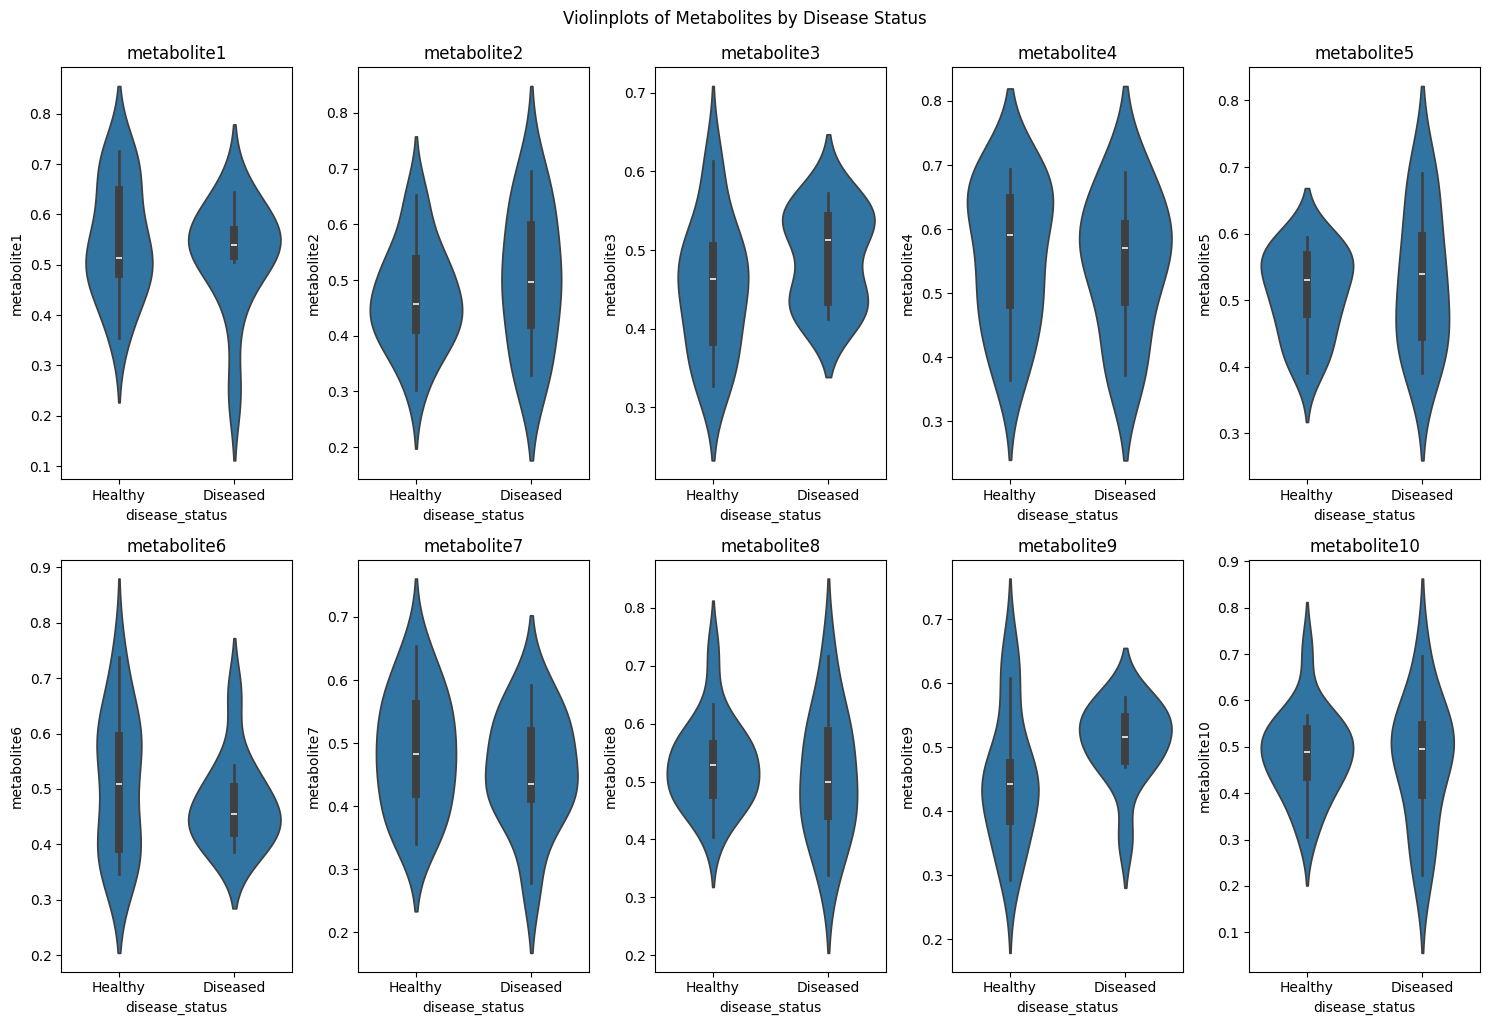

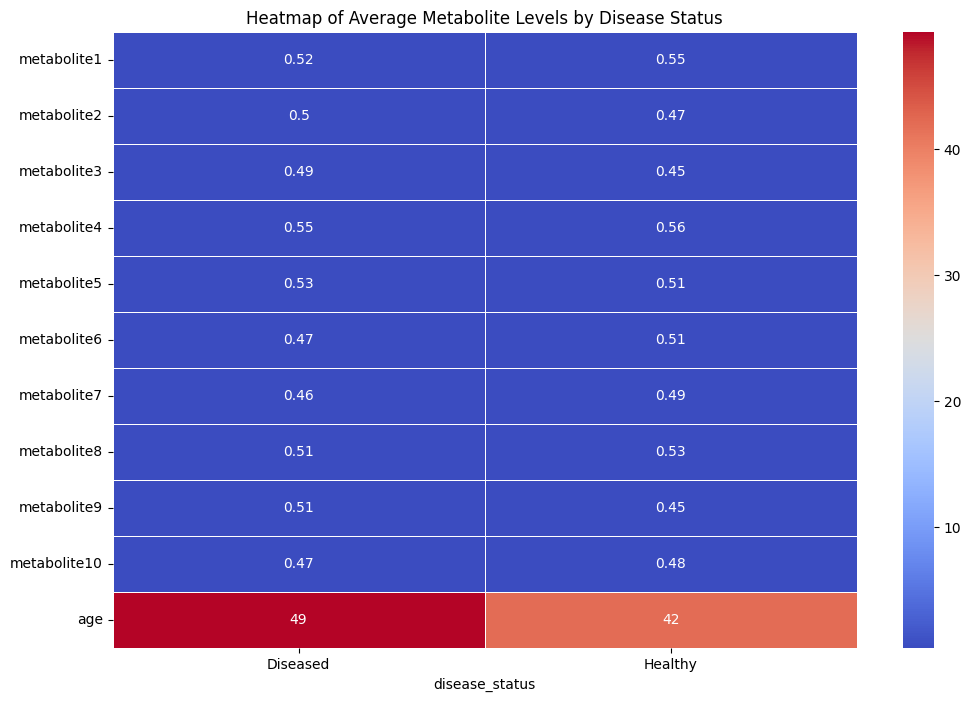

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Violinplot der Metaboliten nach Krankheitsstatus
plt.figure(figsize=(15, 10))
for i, metabolite in enumerate(metabolites):
    plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns
    sns.violinplot(x='disease_status', y=metabolite, data=df_results)
    plt.title(metabolite)
plt.tight_layout()
plt.suptitle('Violinplots of Metabolites by Disease Status', y=1.02)
plt.show()

# Heatmap der durchschnittlichen Metabolitenwerte
mean_metabolites = df_numeric.groupby('disease_status').mean().T
plt.figure(figsize=(12, 8))
sns.heatmap(mean_metabolites, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Average Metabolite Levels by Disease Status')
plt.show()


In [10]:
import plotly.express as px

# Auswahl von drei wichtigen Metaboliten
fig = px.scatter_3d(df_results, x='metabolite1', y='metabolite2', z='metabolite3',
                    color='disease_status', symbol='gender',
                    title='3D Scatter Plot of Metabolites')
fig.show()

In [12]:
import numpy as np

# Creating a grid of average metabolite values
disease_statuses = df_results['disease_status'].unique()
metabolites = [col for col in df_results.columns if 'metabolite' in col]

mean_values = df_results.groupby('disease_status')[metabolites].mean().T.values

X, Y = np.meshgrid(disease_statuses, metabolites)
Z = mean_values

fig = go.Figure(data=[go.Surface(z=Z, x=Y, y=X)])
fig.update_layout(title='3D Surface Plot of Average Metabolite Levels by Disease Status',
                  scene=dict(xaxis_title='Metabolites',
                             yaxis_title='Disease Status',
                             zaxis_title='Average Level'))
fig.show()

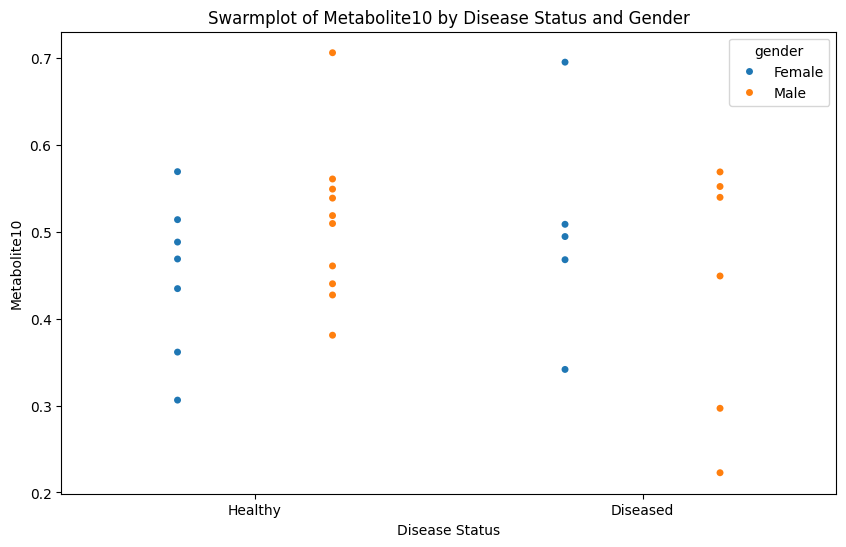

In [15]:
# Swarmplot of metabolite10 by disease status and gender
plt.figure(figsize=(10, 6))
sns.swarmplot(data=df_results, x='disease_status', y='metabolite10', hue='gender', dodge=True)
plt.title('Swarmplot of Metabolite10 by Disease Status and Gender')
plt.xlabel('Disease Status')
plt.ylabel('Metabolite10')
plt.show()


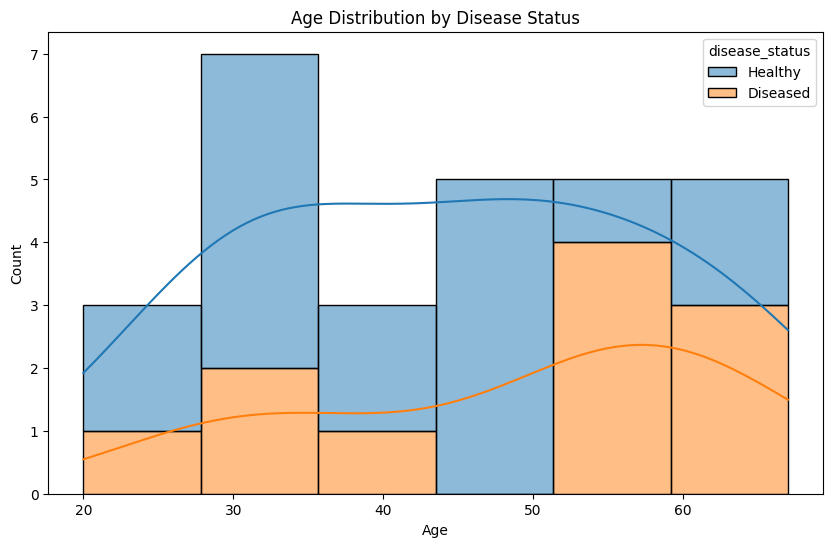

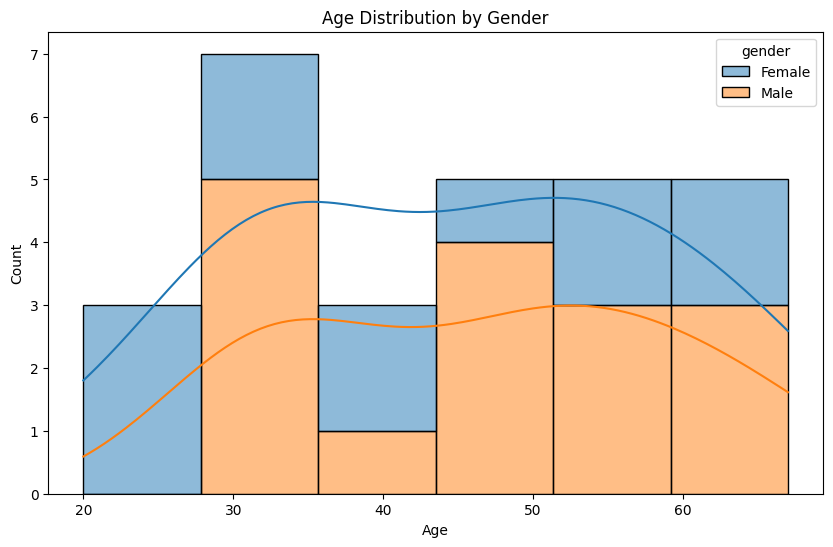

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histogram of age distribution by disease status
plt.figure(figsize=(10, 6))
sns.histplot(data=df_results, x='age', hue='disease_status', multiple='stack', kde=True)
plt.title('Age Distribution by Disease Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Histogram of age distribution by gender
plt.figure(figsize=(10, 6))
sns.histplot(data=df_results, x='age', hue='gender', multiple='stack', kde=True)
plt.title('Age Distribution by Gender')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


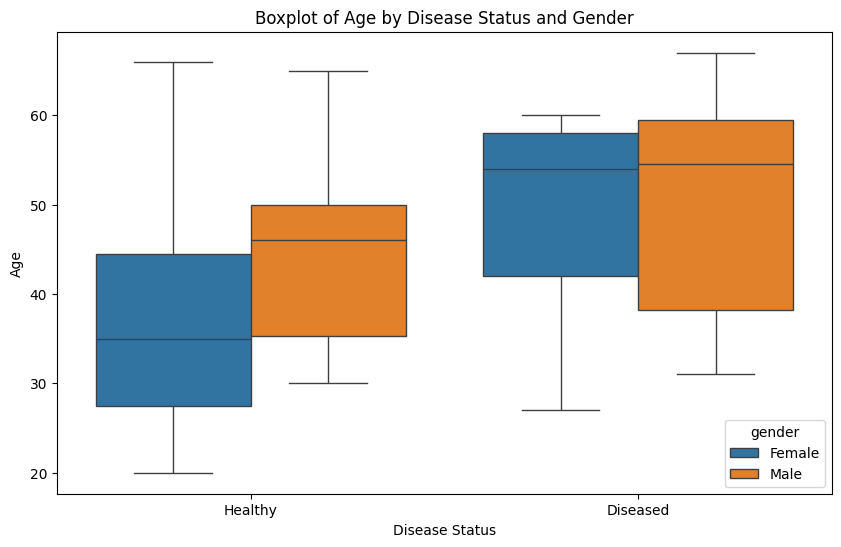

In [19]:
# Boxplot of age by disease status and gender
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_results, x='disease_status', y='age', hue='gender')
plt.title('Boxplot of Age by Disease Status and Gender')
plt.xlabel('Disease Status')
plt.ylabel('Age')
plt.show()

